# Temporal graph analysis
In this notebook we'll take a look at the evolution of the graph, and of clustered modules of the graph, over time.

In [1]:
import networkx as nx
from matplotlib.patches import Circle
from copy import deepcopy
from networkx.algorithms.community.louvain import louvain_communities, louvain_partitions
from statistics import mean, median
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
import numpy as np
from pylab import cm
from matplotlib.colors import rgb2hex
import matplotlib
matplotlib.rcParams["axes.formatter.limits"] = (-99, 99)

## Read in the graphs

In [26]:
dygiepp_graph = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_29Apr2024.graphml')
genophenoenvo = nx.read_graphml('../data/genophenoenvo/genophenoenvo_from_edgelist.graphml')
dygiepp_pure = nx.read_graphml('../data/kg/dygiepp_pure_extraction_graph.graphml')

In [27]:
graphs = {'dygiepp_co-occurrence': dygiepp_graph,
         'genophenoenvo': genophenoenvo,
         'dygiepp_pure_extraction': dygiepp_pure}

## Graph statistics comparison
Quickly want to compare the numebrs of nodes and edge, as well as degree, for each graph to get a sense of how to weigh the rest of the comparisons in this notebook.

In [4]:
g_degs = {}
g_nodes = {}
g_edges = {}
for g_name, graph in graphs.items():
    g_degs[g_name] = graph.degree()
    g_nodes[g_name] = len(graph.nodes)
    g_edges[g_name] = len(graph.edges)
    print(f'\nFor graph {g_name}, there are {len(graph.nodes)} nodes and {len(graph.edges)} edges.')


For graph dygiepp_co-occurrence, there are 334579 nodes and 1289214 edges.

For graph genophenoenvo, there are 409729 nodes and 5318857 edges.

For graph dygiepp_pure_extraction, there are 336120 nodes and 124408 edges.


In [5]:
cmap = cm.get_cmap('tab10')
graph_colors = {g_name: rgb2hex(cmap(i)) for i, g_name in enumerate(graphs.keys())}

/tmp/local/34894485/ipykernel_60013/3032991073.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


In [6]:
centers = {'dygiepp_co-occurrence': (1, 1),
         'genophenoenvo': (1.00001, 1.00001),
         'dygiepp_pure_extraction': (1.000001, 1.000001)}

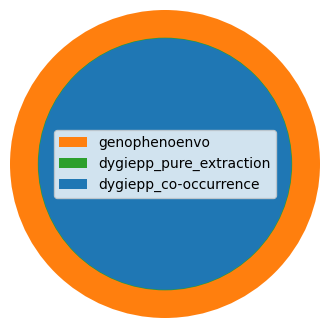

In [7]:
# Plot relative graph sizes
node_circles = {}
for g_name, n_nodes in g_nodes.items():
    to_divide_by = max(g_nodes.values())
    radius = n_nodes / to_divide_by
    this_circle = Circle(centers[g_name], radius, label=g_name, facecolor=graph_colors[g_name])
    node_circles[g_name] = this_circle
node_circles = dict(sorted(node_circles.items(), key=lambda x:x[1].get_radius(), reverse=True))

plt.figure(figsize=(4, 4))
for g_name, circ in node_circles.items():
    plt.gca().add_artist(circ)
_ = plt.ylim(0, 2)
_ = plt.xlim(0, 2)

ax = plt.gca()
_ = ax.axis('off')
_ = plt.legend()

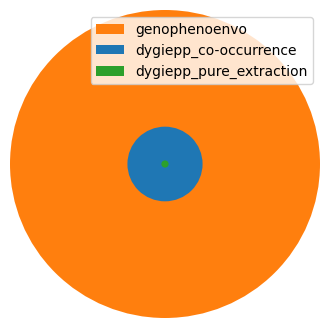

In [8]:
# Plot relative graph sizes
edge_circles = {}
for g_name, n_edges in g_edges.items():
    to_divide_by = max(g_edges.values())
    radius = n_edges / to_divide_by
    this_circle = Circle(centers[g_name], radius, label=g_name, facecolor=graph_colors[g_name])
    edge_circles[g_name] = this_circle
edge_circles = dict(sorted(edge_circles.items(), key=lambda x:x[1].get_radius(), reverse=True))

plt.figure(figsize=(4, 4))
for g_name, circ in edge_circles.items():
    plt.gca().add_artist(circ)
_ = plt.ylim(0, 2)
_ = plt.xlim(0, 2)

ax = plt.gca()
_ = ax.axis('off')
_ = plt.legend()

In [9]:
graph_degs = {g_name: [deg[1] for deg in graph.degree()] for g_name, graph in graphs.items()}
plotting_order = ['genophenoenvo', 'dygiepp_co-occurrence', 'dygiepp_pure_extraction']

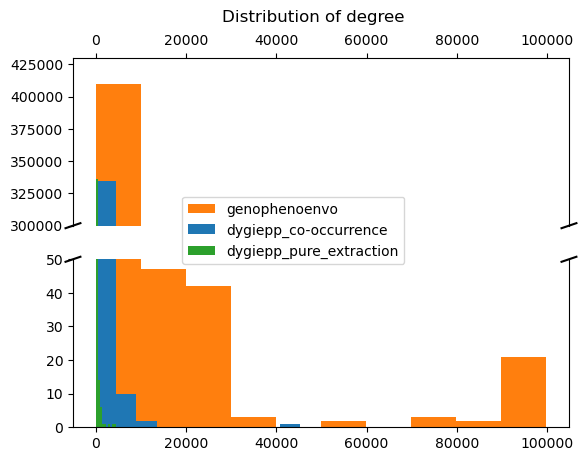

In [10]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for g_name in plotting_order:
    _ = ax1.hist(graph_degs[g_name], color=graph_colors[g_name], label=g_name)
    _ = ax2.hist(graph_degs[g_name], color=graph_colors[g_name])

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-3]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 50) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

_ = fig.suptitle('Distribution of degree')
_ = fig.legend(loc='center')

## Community detection
We want to use community detection (graph clustering) to get highly connected neighborhoods of nodes, so that we can examine how different parts of the graph evolve over time.

While our graph isn't exactly a biological network in the traditional sense (not derived directly from biological data), it still reflects relationships between biolosical entities like genes and proteins. We'll use the Louvain clustering method, as (a) it's a good community detection algorithm for any network type, and (b) [this paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2746-0) demonstrated that it works the best on biological gene networks.

In [11]:
graph_clusters_with_isolates = {}
for g_name, graph in graphs.items():
    clusters = louvain_communities(graph, seed=1234)
    graph_clusters_with_isolates[g_name] = clusters
    cluster_lens = [len(c) for c in clusters]
    print(f'For graph {g_name}, there are {len(clusters)} clusters, with a mean membership of {mean(cluster_lens)} nodes, and a median membership of '
     f'{median(cluster_lens)} nodes. The maximum cluster size is {max(cluster_lens)}, and the minimum size is {min(cluster_lens)}.')

For graph dygiepp_co-occurrence, there are 47145 clusters, with a mean membership of 7.096807720861173 nodes, and a median membership of 1 nodes. The maximum cluster size is 43328, and the minimum size is 1.
For graph genophenoenvo, there are 293 clusters, with a mean membership of 1398.3924914675767 nodes, and a median membership of 6 nodes. The maximum cluster size is 181105, and the minimum size is 1.
For graph dygiepp_pure_extraction, there are 273253 clusters, with a mean membership of 1.2300688373046225 nodes, and a median membership of 1 nodes. The maximum cluster size is 6489, and the minimum size is 1.


In [18]:
print('DROPPING ISOLATES\n')
graph_clusters = {}
cleaned_graphs = {}
for g_name, graph in graphs.items():
    graph = deepcopy(graph)
    isolates = list(nx.isolates(graph))
    graph.remove_nodes_from(isolates)
    cleaned_graphs[g_name] = graph
    print(f'\nDropping {len(isolates)} isolate nodes from graph before performing community detection.')
    clusters = louvain_communities(graph, seed=1234)
    graph_clusters[g_name] = clusters
    cluster_lens = [len(c) for c in clusters]
    print(f'For graph {g_name}, there are {len(clusters)} clusters, with a mean membership of {mean(cluster_lens)} nodes, and a median membership of '
     f'{median(cluster_lens)} nodes. The maximum cluster size is {max(cluster_lens)}, and the minimum size is {min(cluster_lens)}.')

DROPPING ISOLATES


Dropping 35054 isolate nodes from graph before performing community detection.
For graph dygiepp_co-occurrence, there are 11708 clusters, with a mean membership of 25.58293474547318 nodes, and a median membership of 2.0 nodes. The maximum cluster size is 31341, and the minimum size is 2.

Dropping 0 isolate nodes from graph before performing community detection.
For graph genophenoenvo, there are 293 clusters, with a mean membership of 1398.3924914675767 nodes, and a median membership of 6 nodes. The maximum cluster size is 181105, and the minimum size is 1.

Dropping 268851 isolate nodes from graph before performing community detection.
For graph dygiepp_pure_extraction, there are 4391 clusters, with a mean membership of 15.319744932817127 nodes, and a median membership of 2 nodes. The maximum cluster size is 6709, and the minimum size is 1.


## Evolution over time
We want to analyze both the full graph, as well as the clusters, for their evolution over time. We'll do that here, and quantify various characteristics at each time step:
* Number of edges
* Number of nodes
* Average degree
* Number of overall Louvain communities present
* Proportion of nodes/edges belonging to each dataset
* For each Louvain community, the number of nodes and their average degree

The genophenoenvo graph does not have a time component, so we will not be able to move forward with it for the rest of this analysis. The DyGIE++ pure extraction graph would need time added to it retroactively, and as we have established that it is too small, we will also not use it in the following analysis.

### Data processing

In [37]:
def evolution_over_time(graph, cuts, clusters):
    """
    Cut the graph at various timepoints and calculate various values at each step.

    parameters:
        graph, networkx Graph: graph to analyze
        cuts, list of int: list of years at which to make cuts
        clusters, list of set: 

    returns:
        graph_at_year, dict: keys are years, values are graphs
        params_over_time, dict of dict: keys are parameters, values are dicts where
            keys are years, values are the value of the parameter at that year
        cluster_w_id, dict: keys are cluster IDs, values are cluster membership
    """
    cluster_w_id = {i: c for i, c in enumerate(clusters)}
    ent2community = {e: i for i, c in cluster_w_id.items() for e in c}
    
    graph_at_year = {}
    for year in cuts:
        nodes = [(n, attrs) for n, attrs in graph.nodes(data=True) if int(attrs['first_year_mentioned']) < year]
        edges = [(e1, e2, attrs) for e1, e2, attrs in graph.edges(data=True) if int(attrs['first_year_mentioned']) < year]
        year_graph = nx.Graph()
        _ = year_graph.add_nodes_from(nodes)
        _ = year_graph.add_edges_from(edges)
        graph_at_year[year] = year_graph
    
    params_over_time = defaultdict(dict)
    for year, year_graph in graph_at_year.items():
        # Number of edges
        params_over_time['num_edges'][year] = len(year_graph.edges)
        # Number of nodes
        params_over_time['num_nodes'][year] = len(year_graph.nodes)
        # Average degree
        ent_and_deg = year_graph.degree()
        all_degs = [deg[1] for deg in ent_and_deg]
        params_over_time['avg_degree'][year] = mean(all_degs)
        # Number of Louvain communities present
        comms = set([ent2community[n] for n in year_graph.nodes])
        params_over_time['num_louvain'][year] = len(comms)
        # Num nodes/edges in each group
        each_group_nodes = defaultdict(int)
        each_group_degs = defaultdict(list)
        for n, attrs in year_graph.nodes(data=True):
            if attrs['is_desiccation']:
                if attrs['is_drought']:
                    each_group_nodes['both'] += 1
                    each_group_degs['both'].append(ent_and_deg[n])
                else:
                    each_group_nodes['desiccation'] += 1
                    each_group_degs['desiccation'].append(ent_and_deg[n])
            elif attrs['is_drought']:
                if not attrs['is_desiccation']:
                    each_group_nodes['drought'] += 1
                    each_group_degs['drought'].append(ent_and_deg[n])
        each_group_edges = defaultdict(int)
        for e1, e2, attrs in year_graph.edges(data=True):
            if attrs['is_desiccation']:
                if attrs['is_drought']:
                    each_group_edges['both'] += 1
                else:
                    each_group_edges['desiccation'] += 1
            elif attrs['is_drought']:
                if not attrs['is_desiccation']:
                    each_group_edges['drought'] += 1
        params_over_time['group_nums_nodes'][year] = each_group_nodes
        params_over_time['group_avg_degree'][year] = {g: mean(d) for g, d in each_group_degs.items()}
        params_over_time['group_nums_edges'][year] = each_group_edges
        # For each community, number of nodes and average degree
        comm_nodes = defaultdict(list)
        for n in year_graph.nodes:
            comm = ent2community[n]
            comm_nodes[comm].append(n)
        louvain_stats = {}
        for comm, comm_ns in comm_nodes.items():
            louv_degs = [ent_and_deg[n] for n in comm_ns]
            louv_nodes = len(comm_ns)
            louvain_stats[comm] = {'avg_degree': mean(louv_degs), 'num_nodes': louv_nodes}
        params_over_time['louvain_stats'][year] = louvain_stats
    
    return graph_at_year, params_over_time, cluster_w_id     

In [38]:
cuts = [1990, 2000, 2010, 2020, 2030]
graph_at_year, params_over_time, cluster_w_id = evolution_over_time(cleaned_graphs['dygiepp_co-occurrence'], cuts, graph_clusters['dygiepp_co-occurrence'])

### Visualizations

In [39]:
single_param_semantic_names = {
    'num_edges': 'Number of edges',
    'num_nodes': 'Number of nodes',
    'avg_degree': 'Average degree',
    'num_louvain': 'Number of communities present',
}

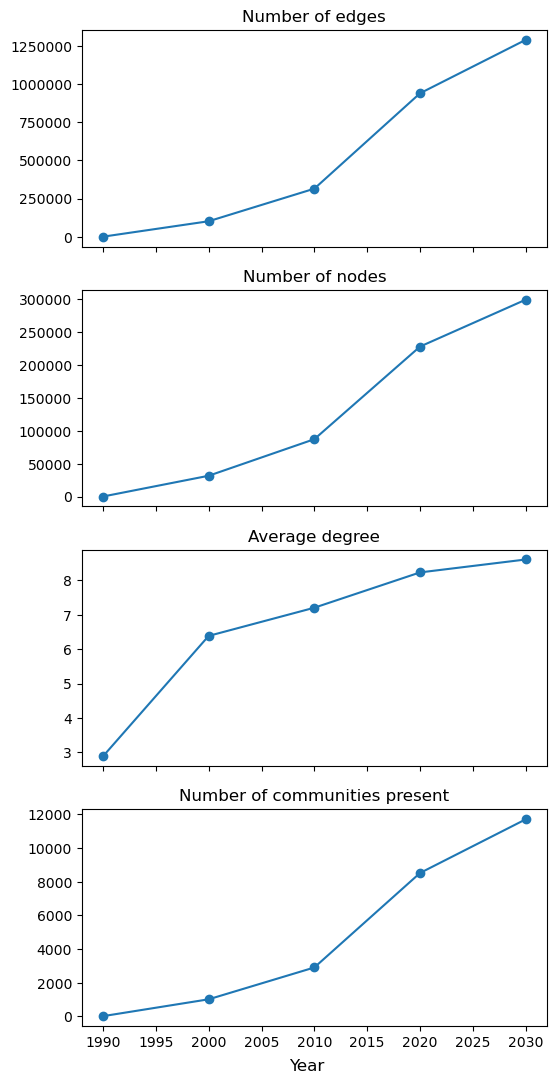

In [40]:
fig, axs = plt.subplots(4, 1, figsize=(6, 12), sharex=True)

for name, ax in zip(single_param_semantic_names.keys(), axs):
    ax.plot(params_over_time[name].keys(), params_over_time[name].values(), marker='o')
    ax.set_title(single_param_semantic_names[name])

fig.supxlabel('Year')
plt.subplots_adjust(bottom=0.05)

We can't visualize all Louvain clusters because there are ~50,000 of them, so let's take a look at the ten largest:

In [41]:
largest_comms = dict(sorted(cluster_w_id.items(), key=itemgetter(1), reverse=True)[:10])

In [42]:
print(f'The ID\'s of the ten largest communities are: {", ".join([str(k) for k in largest_comms.keys()])}')
print(f'The sizes of the ten largest communities are: {", ".join([str(len(v)) for v in largest_comms.values()])}')

The ID's of the ten largest communities are: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
The sizes of the ten largest communities are: 2, 8543, 30705, 28, 12, 3015, 2, 3809, 25, 2


In [43]:
comm_deg = {y: {i: d['avg_degree'] for i, d in p.items() if i in largest_comms.keys()} for y, p in params_over_time['louvain_stats'].items()}
comm_num = {y: {i: d['num_nodes'] for i, d in p.items() if i in largest_comms.keys()} for y, p in params_over_time['louvain_stats'].items()}

In [44]:
deg_by_cluster = {}
for comm_id in comm_deg[2030].keys():
    degs = {}
    for year, deg in comm_deg.items():
        try:
            this_deg = deg[comm_id]
        except KeyError:
            this_deg = np.nan
        degs[year] = this_deg
    deg_by_cluster[comm_id] = degs

num_by_cluster = {}
for comm_id in comm_num[2030].keys():
    nums = {}
    for year, num in comm_num.items():
        try:
            this_num = num[comm_id]
        except KeyError:
            this_num = np.nan
        nums[year] = this_num
    num_by_cluster[comm_id] = nums

In [45]:
clust_colors = {i: rgb2hex(cmap(i)) for i in range(10)}

Text(0.5, 0.01, 'Year')

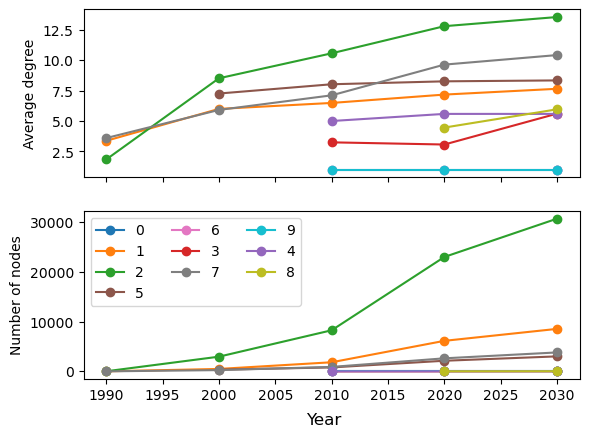

In [47]:
fig, axs = plt.subplots(2, 1, sharex=True)

for clust, degs in deg_by_cluster.items():
    axs[0].plot(degs.keys(), degs.values(), color=clust_colors[clust], label=clust, marker='o')
axs[0].set_ylabel('Average degree')
for clust, nums in num_by_cluster.items():
    axs[1].plot(nums.keys(), nums.values(), color=clust_colors[clust], label=clust, marker='o')
axs[1].set_ylabel('Number of nodes')
axs[1].legend(ncol=3)
fig.supxlabel('Year')

Now let's look at the breakdown of drought vs. desiccation vs. both:

In [48]:
attrs = ['group_nums_nodes', 'group_avg_degree', 'group_nums_edges']
groups = ['desiccation', 'drought', 'both']
all_group_attrs = {}
for attr in attrs:
    this_name_formatted = {}
    for group in groups:
        group_vals = {}
        for year in cuts:
            try:
                group_vals[year] = params_over_time[attr][year][group]
            except KeyError:
                group_vals[year] = np.nan
        this_name_formatted[group] = group_vals
    all_group_attrs[attr] = this_name_formatted

In [49]:
group_colors = {grp: rgb2hex(cmap(i)) for i, grp in enumerate(groups)}

In [50]:
semantic_attr_names = {
    'group_nums_nodes': 'Number of nodes',
    'group_avg_degree': 'Average degree',
    'group_nums_edges': 'Number of edges'
}

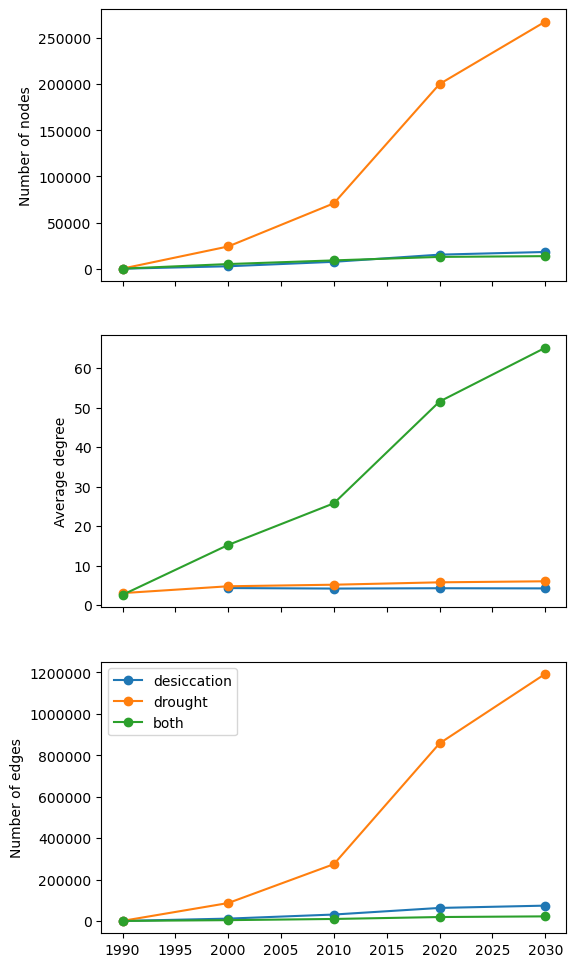

In [51]:
fig, axs = plt.subplots(3, 1, figsize=(6,12), sharex=True)

for attr, ax in zip(all_group_attrs.keys(), axs):
    for group, to_plot in all_group_attrs[attr].items():
        ax.plot(to_plot.keys(), to_plot.values(), color=group_colors[group], marker='o', label=group)
    ax.set_ylabel(semantic_attr_names[attr])
plt.legend()

There is a very interesting finding here! The degree for the articles that are shared between the drought and desiccation datasets increases much more than for either drought or desiccation alone over time. Need to make sure that's not a bug, because it's a little bit suspicious.